# Neural Network Overview
## Image Classification using ResNet

<img src="images/CNN.jpg" style="width:950px;height:400px;">
<caption><left>[*image source](https://www.MathWorks.com)</left></caption><br>

The following Notebook demonstrates this process by using SageMaker's built-in [Image Classification Algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html). To accomplish this, SageMaker's Image Classification Algorithm leverages a commonly used and pre-built model for image classification called __Resnet__ (You can read more about Resnet [here](https://arxiv.org/abs/1512.03385)).

By leveraging this methadology, the Data Scientist or Developer doesn't need to expend time to build, train and optmize a custom Image Classification models, but rather simply provide the training data and left SageMaker perform all the heavy lifting.

In [1]:
# Import libraries
import warnings; warnings.simplefilter('ignore')
import os
import boto3
import sagemaker
import time
import h5py
import json
import tarfile
import datetime
import urllib.request
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from time import gmtime, strftime
from IPython.display import Image
from sagemaker.amazon.amazon_estimator import get_image_uri
%matplotlib inline

# Configure SageMaker
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
training_image = get_image_uri(boto3.Session().region_name, 'image-classification') #Image Classification Estimator

---
# Data Overview
## Input Data Preparation
To train the Neural Network, we are provided with a dataset (`datasets.h5`) containing:
- a training set of $m$ images containing cats and non-cats as well as the appropriate class labels ($y=1$) and non-cat images ($y=0$).
- a test set of $m$ images containing cats and non-cat as well as the appropriate class labels ($y=1$) and non-cat images ($y=0$).

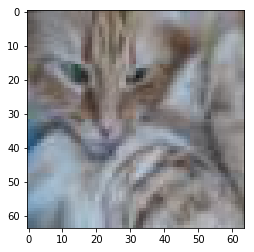

In [2]:
# Show sample image from file
from PIL import Image
image = mpimg.imread('./datasets/train/2.jpg')
plt.imshow(image);

In [3]:
# Upload the Training and Testing Data to S3
training_data = sagemaker_session.upload_data(path='./datasets/train', key_prefix='train')
training_lst = sagemaker_session.upload_data(path='./datasets/train.lst', key_prefix='train_lst')
test_data = sagemaker_session.upload_data(path='./datasets/test', key_prefix='test')
test_lst = sagemaker_session.upload_data(path='./datasets/test.lst', key_prefix='test_lst')
bucket = training_data.split('/')[2]
print("S3 Bucket: {}".format(bucket))

INFO:sagemaker:Created S3 bucket: sagemaker-us-west-2-500842391574


S3 Bucket: sagemaker-us-west-2-500842391574


---

# Training the SageMaker Classifier
## Hyperparameters

In [4]:
# The algorithm supports multiple network depth (number of layers). They are 18, 34, 50, 101, 152 and 200
num_layers = 18

# Shape of the training images
image_shape = "3,64,64"

# No. Samples in Training set
num_training_samples = 209

# No. output classes
num_classes = 2

# Batch Size
mini_batch_size =  42

# No. Epochs
epochs = 6

# Learning rate
learning_rate = 0.01

# Since transfer learning is not used, set use_pretrained_model to `0`
# so that weights can be initialized WITHOUT pre-trained weights
use_pretrained_model = 0

## Training Configuration

In [5]:
# Create unique job name 
job_name_prefix = 'sagemaker-imageclassification-demo'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = job_name_prefix + timestamp
training_params = \
{
    # Specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket, job_name_prefix)
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.xlarge", # GPU Instance
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_shape": image_shape,
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate),
        "use_pretrained_model": str(use_pretrained_model)    
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },
    "InputDataConfig": [
        {
            "ChannelName": "train", # Training Images Location
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation", # Testing Images Location
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",
            "CompressionType": "None"
        },
        {
            "ChannelName": "train_lst", # Image Metadata
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/train_lst/'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation_lst", # Image metadata
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/test_lst/'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",
            "CompressionType": "None"
        }
    ]
}
print('Training job name: {}'.format(job_name))

Training job name: sagemaker-imageclassification-demo-2018-08-08-17-09-35


## Training Job

In [6]:
# create the Amazon SageMaker training job
sagemaker = boto3.client(service_name='sagemaker')
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

Training job current status: InProgress
Training job ended with status: Completed


---
# Hosting the SageMaker Model
## Create Model
__Create a SageMaker Model from the training output, using the model to Nextcreate an Endpoint Configuration.__

In [7]:
# Create hosting model
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
model_name = "image-classification-demo" + timestamp
info = sagemaker.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print("Model mame: {}".format(model_name))

# SageMaker Hossting Image
hosting_image = get_image_uri(boto3.Session().region_name, 'image-classification')
primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

# Create the Model
create_model_response = sagemaker.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container
)

Model mame: image-classification-demo-2018-08-08-17-15-35


## Create the Endpoint Configuration
Next, configure REST endpoints for hosting multiple models, e.g. for A/B testing purposes. In order to support this, create an endpoint configuration, that describes the distribution of traffic across the models, whether split, shadowed, or sampled in some way. In addition, the endpoint configuration describes the instance type required for model deployment, and at launch will describe the autoscaling configuration.

In [8]:
# Create the Endpoint configuration
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name_prefix + '-config' + timestamp
endpoint_config_response = sagemaker.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants = [
        {
            'InstanceType':'ml.m5.xlarge', # Non-GPU Instance for hosting
            'InitialInstanceCount':1,
            'ModelName':model_name,
            'VariantName':'AllTraffic'
        }
    ]
)
print('Endpoint configuration name: {}'.format(endpoint_config_name))

Endpoint configuration name: sagemaker-imageclassification-demo-config-2018-08-08-17-15-36


## Create Hosting Endpoint
Through specifying the name and configuration defined above an endpoint is created that will be used to predictions on un-seen data as well as incorporated into production applications. This takes 9-11 minutes to complete.

In [9]:
# Create Endpoint
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name_prefix + '-endpoint' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)

# get the status of the endpoint
response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))
    
try:
    sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)
finally:
    resp = sagemaker.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Arn: " + resp['EndpointArn'])
    print("Create endpoint ended with status: " + status)

    if status != 'InService':
        message = sagemaker.describe_endpoint(EndpointName=endpoint_name)['FailureReason']
        print('Training failed with the following error: {}'.format(message))
        raise Exception('Endpoint creation did not succeed')

Endpoint name: sagemaker-imageclassification-demo-endpoint-2018-08-08-17-15-36
EndpointStatus = Creating
Arn: arn:aws:sagemaker:us-west-2:500842391574:endpoint/sagemaker-imageclassification-demo-endpoint-2018-08-08-17-15-36
Create endpoint ended with status: InService


---
# Prediction

Finally, the endpoint can be obtained from the client library using the result from previous operations, and generate classifications from the trained model using that endpoint to predict whether a new (previously unseen) image is classified as a **cat** or **non-cat** image.

Image is a cat picture.


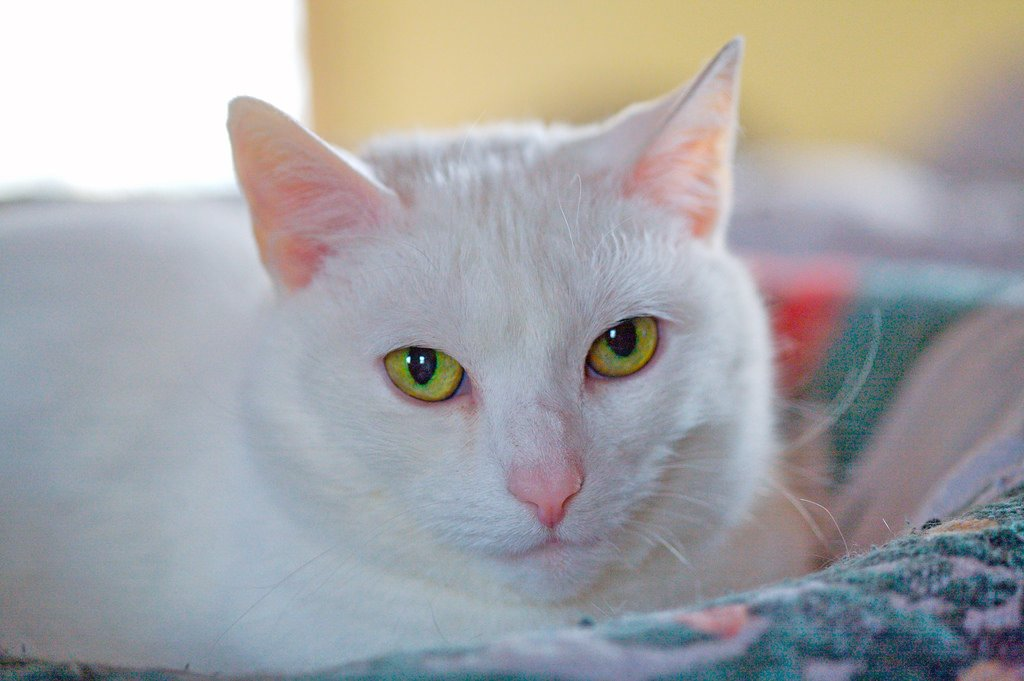

In [10]:
from IPython.display import Image

# Create the Endpoint invocation parameters
classes = ["non-cat", "cat"]
threshold = 0.9
runtime = boto3.Session().client(service_name='runtime.sagemaker')

# Display `cat` Image
my_image = "my_image2.jpeg"
fname = "images/" + my_image
with open(fname, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = json.loads(response['Body'].read())
index = np.argmax(result)
#print(result[index])
if result[index] < threshold:
    prediction = classes[1]
else:
    prediction = classes[0]

# Plot the final image
print("Image is a {} picture.".format(prediction))
Image(fname)

Image is a non-cat picture.


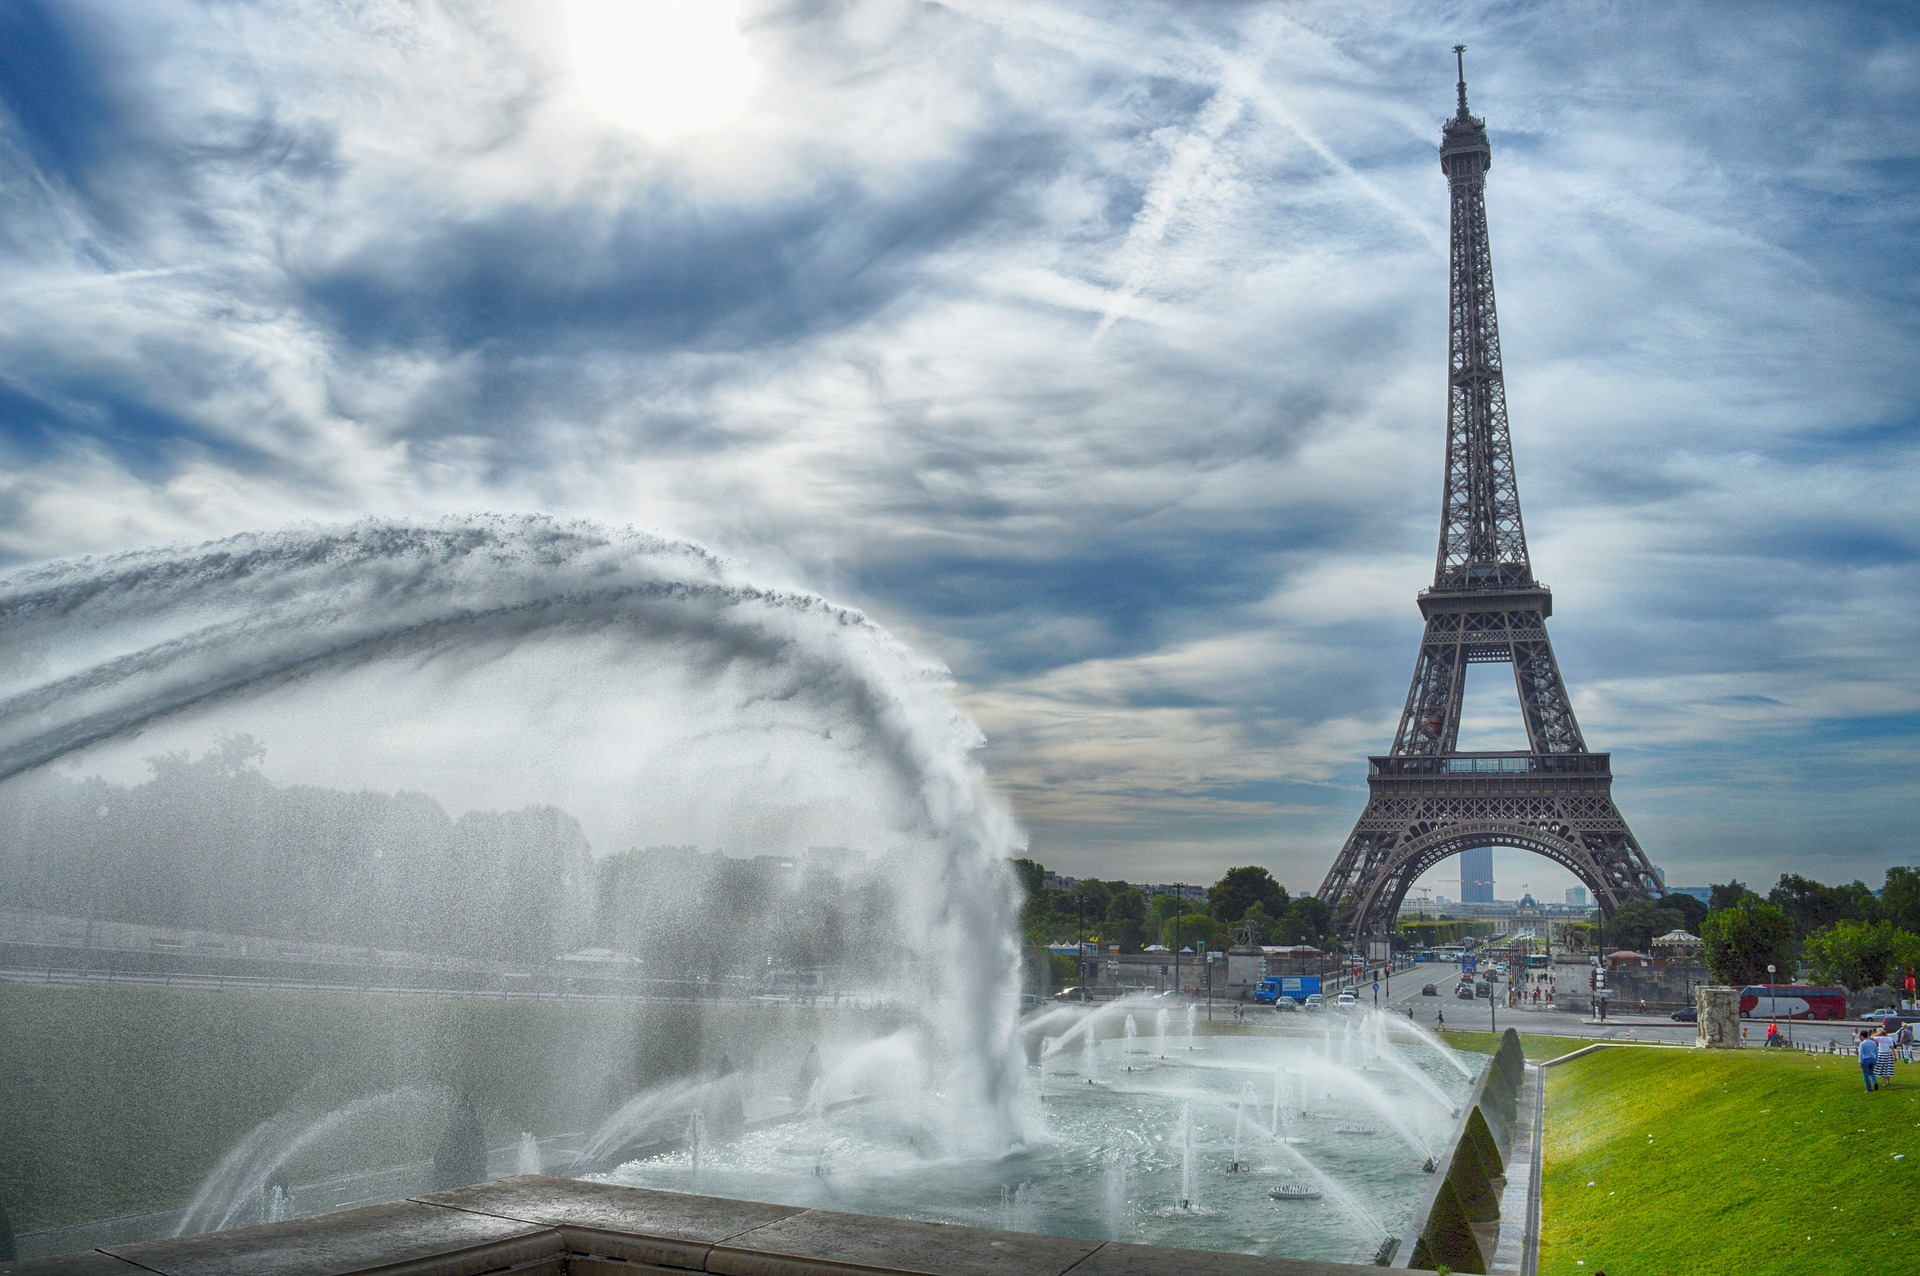

In [11]:
# display `non-cat` Image
my_image = "my_image.jpeg"
fname = "images/" + my_image
with open(fname, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = json.loads(response['Body'].read())
index = np.argmax(result)
#print(result[index])
if result[index] < threshold:
    prediction = classes[1]
else:
    prediction = classes[0]

# Plot the final image
print("Image is a {} picture.".format(prediction))
Image(fname)